In [2]:
#import sys
#sys.version
import modelbase
import modelbase.ratelaws as rl
from weisse import WeisseBaseModel

import numpy as np
import matplotlib.pyplot as plt


In [3]:
defaultParameters = { 's': 1e4,  # external nutrient [ molecs ]
                      'dm': 0.1,  # mRNA degradation rate [1/min ]
                      'ns': 0.8,  # nutrient efficiency [ none ]
                      'nr': 7459,  # ribosome length [ aa / molecs ]
                      'nt': 300,  # length of non-ribosomal proteins [ aa / molecs ]
                      'nm': 300,  # length of non-ribosomal proteins [ aa / molecs ]
                      'nq': 300,  # length of non-ribosomal proteins [ aa / molecs ]
                      'gammamax': 1260,  # max. transl. elongation rate [ aa / min molecs ]
                      'Kgamma': 7,  # transl. elongation threshold [ molecs / cell ]
                      'vt': 726,  # max. nutrient import rate [ 1/min ]
                      'Kt': 1000,  # nutrient import threshold [ molecs ]
                      'vm': 5800,  # max. enzymatic rate [ 1/min ]
                      'Km': 1000,  # enzymatic threshold
                      'wr': 930,  # max. ribosome transcription rate [ molecs / min cell ]
                      'wt': 4.14,  # max. enzyme transcription rate [ molecs / min cell ]
                      'wm': 4.14,  # max. enzyme transcription rate [ molecs / min cell ]
                      'wq': 948.93,  # max. q-transcription rate
                      'thetar': 426.87,  # ribosome transcription threshold [ molecs / cell ]
                      'thetat': 4.38,  # non-ribosomal transcription threshold [ molecs / cell ]
                      'thetam': 4.38,  # non-ribosomal transcription threshold [ molecs / cell ]
                      'thetaq': 4.38,  # non-ribosomal transcription threshold [ molecs / cell ]
                      'Kq': 152219,  # q-autoinhibition threshold [ molecs / cell ]
                      'hq': 4,  # q-autoinhibition Hill coeff. [ none ]
                      'kb': 1,  # mRNA-ribosome binding rate
                      'ku': 1,  # mRNA-ribosome unbinding rate
                      'M': 1e8,  # total cell mass
                      'kcm': 0.00599  # chloramphenicol-binding rate
}

In [4]:
indexx = ['r','t','m','q']
cl = ['si','a','mr','mt','mm','mq', 'cr','ct','cm','cq','pr','pt','pm','pq']

In [5]:
"""

class WeisseBaseModel(modelbase.Model):
    '''
    class to define the basic model proposed by Weiße et al, 2015, PNAS
    '''

    def __init__(self, pars = {}):
        '''
        constructor method for basic Weisse model
        '''

        defPars = defaultParameters.copy()

        super(WeisseBaseModel,self).__init__(defPars)

        self.par.update(pars)

        self.add_cpds(['si','a']) # si: internal substrate, a: energy
        self.add_cpds(['m'+x for x in indexx]) # mRNA
        self.add_cpds(['c'+x for x in indexx]) # RNA/protein complexes
        self.add_cpds(['p'+x for x in indexx]) # proteins

        def gamma(par, a):
            return np.array([par.gammamax * a[0] / (par.Kgamma + a[0])])
        self.add_algebraicModule(gamma, 'gamma', ['a'], ['gamma'])
        
        def vimp(par, et):
            return et * par.vt * par.s / (par.Kt + par.s)
        self.add_reaction('vimp',vimp,{'si':1},'pt')

        def vcat(par, em, si):
            return em * par.vm * si / (par.Km + si)
        self.add_reaction('vcat',vcat,{'si':-1,'a':self.par.ns},'pm','si')

        def makevx(x):
            def vx(par, cx, gamma):
                return cx * gamma / getattr(par,'n'+x)
            return vx
        
        for x in indexx: # all vx's
            rname = 'v'+x
            cx = 'c'+x
            nx = 'n'+x
            mx = 'm'+x
            px = 'p'+x
            stDict = {'a':-getattr(self.par,nx), 'pr': 1, px: 1, mx: 1, cx: -1}
            if x == 'r':
                stDict['pr'] = 2
            vx = makevx(x)
            self.add_reaction(rname, vx, stDict, cx, 'gamma')
            
        def complexbu(par, r, mx, cx):
            return par.kb * r * mx - par.ku * cx

        for x in indexx: # all complex binding/unbinding reactions
            rname = 'cbu'+x
            mx = 'm'+x
            cx = 'c'+x
            stDict = {'pr':-1, mx: -1, cx: 1}
            self.add_reaction(rname, complexbu, stDict, 'pr', mx, cx)

        def inhibitionq(par, q):
            return np.array([1 / (1 + (q[0]/par.Kq) ** par.hq)])
        self.add_algebraicModule(inhibitionq, 'Iq', ['pq'], ['Iq'])
                    
        def makeomegax(x):
            def omegax(par, a):
                return getattr(par, 'w'+x) * a / (getattr(par, 'theta'+x) + a)
            return omegax

        def degmx(par, mx):
            return par.dm * mx
            
        for x in indexx: # all transcription rates omegax
            rname = 'omega'+x
            mx = 'm'+x
            stDict = {mx: 1}
            if x == 'q':
                def omegax(par, a, Iq):
                    return Iq * par.wq * a / (par.thetaq + a)
                self.add_reaction(rname, omegax, stDict, 'a', 'Iq')
            else:
                omegax = makeomegax(x)
                self.add_reaction(rname, omegax, stDict, 'a')
            
            stDictDeg = {mx: -1}
            self.add_reaction('degm'+x, degmx, stDictDeg, mx)

        def stGrowth(par, y):
            return np.array([y[0] * y[1:].sum() / par.M])
        self.add_algebraicModule(stGrowth, 'lambda', ['gamma', 'cr', 'ct', 'cm', 'cq'], ['lambda'])

        def dilution(par, lam, x):
            return lam * x

        for cpd in self.cpdNames:
            rname = 'dilution_'+cpd
            stDict = {cpd: -1}
            self.add_reaction(rname, dilution, stDict, 'lambda', cpd)
"""

"\n\nclass WeisseBaseModel(modelbase.Model):\n    '''\n    class to define the basic model proposed by Weiße et al, 2015, PNAS\n    '''\n\n    def __init__(self, pars = {}):\n        '''\n        constructor method for basic Weisse model\n        '''\n\n        defPars = defaultParameters.copy()\n\n        super(WeisseBaseModel,self).__init__(defPars)\n\n        self.par.update(pars)\n\n        self.add_cpds(['si','a']) # si: internal substrate, a: energy\n        self.add_cpds(['m'+x for x in indexx]) # mRNA\n        self.add_cpds(['c'+x for x in indexx]) # RNA/protein complexes\n        self.add_cpds(['p'+x for x in indexx]) # proteins\n\n        def gamma(par, a):\n            return np.array([par.gammamax * a[0] / (par.Kgamma + a[0])])\n        self.add_algebraicModule(gamma, 'gamma', ['a'], ['gamma'])\n        \n        def vimp(par, et):\n            return et * par.vt * par.s / (par.Kt + par.s)\n        self.add_reaction('vimp',vimp,{'si':1},'pt')\n\n        def vcat(par, em, si

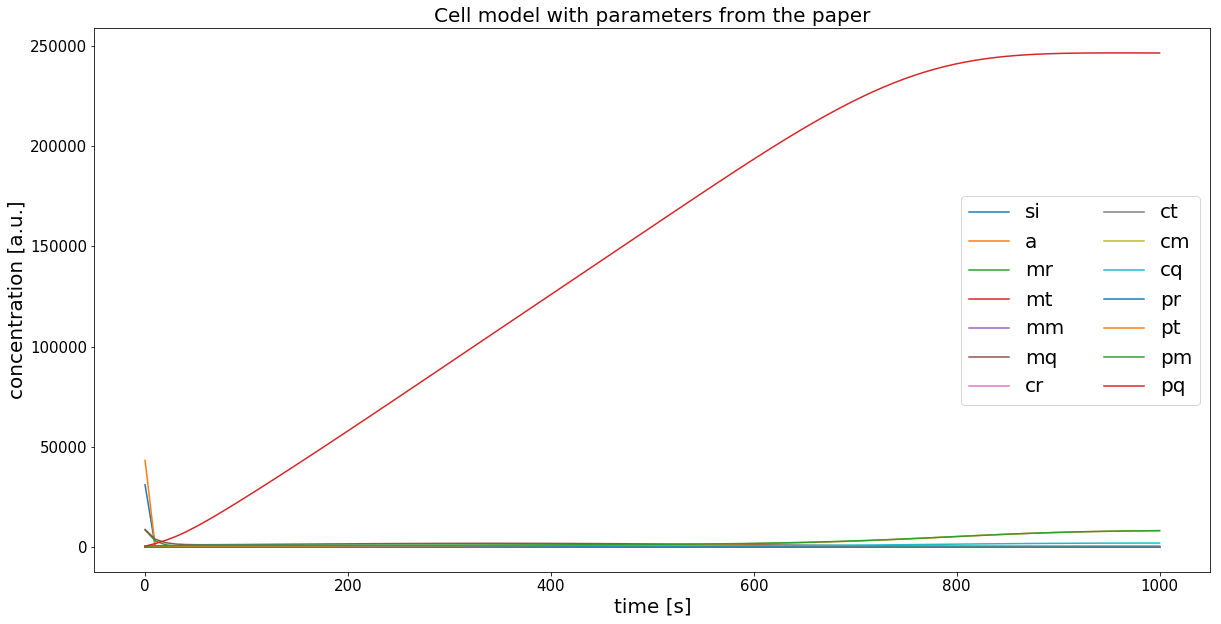

In [7]:
m = WeisseBaseModel({'ns':0.3})
s = modelbase.Simulator(m)
#                         ['si',       'a',     'mr',     'mt',   'mm',    'mq',    'cr', 'ct', 'cm', 'cq', 'pr',   'pt',    'pm',     'pq']
weise_values = np.array([31096.192, 43297.502, 8514.558, 49.333, 49.333, 8811.960, 348.675, 0, 357.898, 0, 0.0414, 471.364, 471.364 , 471.364])
s.timeCourse(np.linspace(0,1000,100),weise_values); 
#s.timeCourse(np.linspace(0,10000,1000),np.ones(14));


# Plotten Sie die zeitliche Entwicklung
plt.figure(figsize=(20,10))
plt.title('Cell model with parameters from the paper', size = 20)
plt.xlabel('time [s]', size = 20)
plt.ylabel('concentration [a.u.]', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
lines = plt.plot(s.getT(),s.getVarsByName(cl))
plt.legend(lines[:14], cl, prop = {'size': 20}, loc = 'center right', frameon=True, ncol=2)

plt.draw_if_interactive()
plt.show()

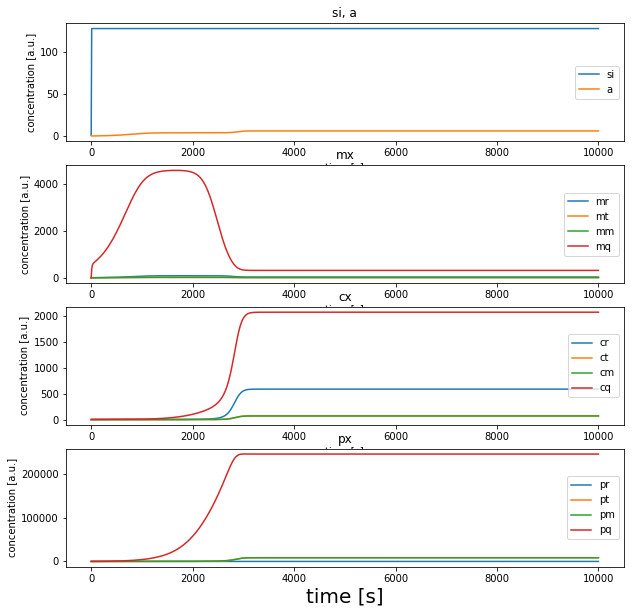

In [6]:
# Plotten Sie die zeitliche Entwicklung
fig, Plotlist = plt.subplots(4,1,figsize=(10,10))
Plotlist = Plotlist.ravel()
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[0:1]),label = cl[0])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[1:2]),label = cl[1])
Plotlist[0].set_title('si, a')
Plotlist[0].set_xlabel('time [s]')
Plotlist[0].set_ylabel('concentration [a.u.]')
Plotlist[0].legend(loc = 'center right')


Plotlist[1].plot(s.getT(),s.getVarsByName(cl[2:3]),label = cl[2])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[3:4]),label = cl[3])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[4:5]),label = cl[4])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[5:6]),label = cl[5])
Plotlist[1].set_title('mx')
Plotlist[1].set_xlabel('time [s]')
Plotlist[1].set_ylabel('concentration [a.u.]')
Plotlist[1].legend(loc = 'center right')


Plotlist[2].plot(s.getT(),s.getVarsByName(cl[6:7]),label = cl[6])
Plotlist[2].plot(s.getT(),s.getVarsByName(cl[7:8]),label = cl[7])
Plotlist[2].plot(s.getT(),s.getVarsByName(cl[8:9]),label = cl[8])
Plotlist[2].plot(s.getT(),s.getVarsByName(cl[9:10]),label = cl[9])
Plotlist[2].set_title('cx')
Plotlist[2].set_xlabel('time [s]')
Plotlist[2].set_ylabel('concentration [a.u.]')
Plotlist[2].legend(loc = 'center right')


Plotlist[3].plot(s.getT(),s.getVarsByName(cl[10:11]), label = cl[10])
Plotlist[3].plot(s.getT(),s.getVarsByName(cl[11:12]),label = cl[11])
Plotlist[3].plot(s.getT(),s.getVarsByName(cl[12:13]),label = cl[12])
Plotlist[3].plot(s.getT(),s.getVarsByName(cl[13:14]),label = cl[13])
Plotlist[3].set_title('px')
Plotlist[3].set_xlabel('time [s]', size = 20)
Plotlist[3].set_ylabel('concentration [a.u.]')
Plotlist[3].legend(loc = 'center right')


[0.00890138 0.000938   0.00094564 0.00095571 0.00096829 0.0009829
 0.00099893 0.00101592 0.00103358 0.00105169 0.00107014 0.00108883
 0.00110773 0.0011268  0.00114601 0.00116538 0.00118488 0.00120453
 0.00122432 0.00124428 0.00126442 0.00128475 0.00130531 0.00132612
 0.00134722 0.00136865 0.00139046 0.00141271 0.00143545 0.00145876
 0.00148272 0.00150742 0.00153295 0.00155943 0.00158698 0.00161573
 0.00164583 0.00167744 0.00171074 0.00174592 0.0017832  0.0018228
 0.001865   0.00191006 0.00195829 0.00201003 0.00206565 0.00212554
 0.00219015 0.00225994 0.00233544 0.00241722 0.00250588 0.0026021
 0.00270658 0.00282009 0.00294347 0.00307759 0.00322338 0.00338182
 0.00355394 0.00374079 0.00394346 0.00416304 0.00440058 0.00465712
 0.00493358 0.00523077 0.00554932 0.00588962 0.00625175 0.00663545
 0.00704002 0.0074643  0.00790661 0.00836475 0.00883598 0.00931709
 0.00980441 0.01029397 0.01078158 0.01126294 0.01173387 0.01219038
 0.01262886 0.01304617 0.01343973 0.01380759 0.01414844 0.0144615

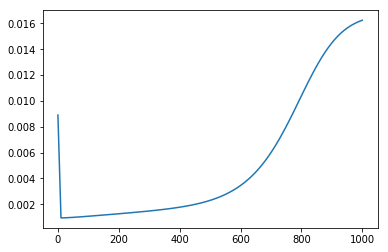

In [15]:
# von jedem zeitschritt aus 100 ist in blub der letzte wert
blub = s.getY()[:,16]
print(blub)
plt.plot(s.getT(),s.getY()[:,16]) #3.10961920e+04

In [8]:
s.model.par.ns

0.3

In [32]:
'''
# Plotten Sie die zeitliche Entwicklung
plt.figure(figsize=(20,10))
plt.title('Cell model with parameters from the paper', size = 20)
plt.xlabel('time [s]', size = 20)
plt.ylabel('concentration [a.u.]', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
lines = plt.plot(s.getT(),s.getVarsByName(cl[]))
plt.legend(lines[:14], cl, prop = {'size': 20}, loc = 'center right', frameon=True, ncol=2)

plt.draw_if_interactive()
plt.show()
'''

"\n# Plotten Sie die zeitliche Entwicklung\nplt.figure(figsize=(20,10))\nplt.title('Cell model with parameters from the paper', size = 20)\nplt.xlabel('time [s]', size = 20)\nplt.ylabel('concentration [a.u.]', size = 20)\nplt.xticks(size = 15)\nplt.yticks(size = 15)\nlines = plt.plot(s.getT(),s.getVarsByName(cl[]))\nplt.legend(lines[:14], cl, prop = {'size': 20}, loc = 'center right', frameon=True, ncol=2)\n\nplt.draw_if_interactive()\nplt.show()\n"